In [140]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from collections.abc import Mapping

In [ ]:
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [141]:
# Load the datasets

batch_size = 256

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = T.ToTensor())
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = T.ToTensor())

valid_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

## Autoencoder

In [142]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,200),
                                    nn.BatchNorm1d(200),
                                    nn.SiLU())
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [ ]:
model = AutoEncoder().to(def_device)

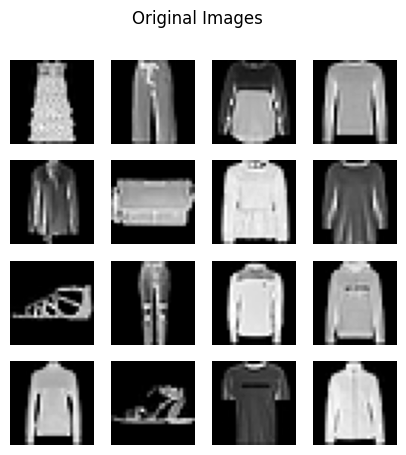

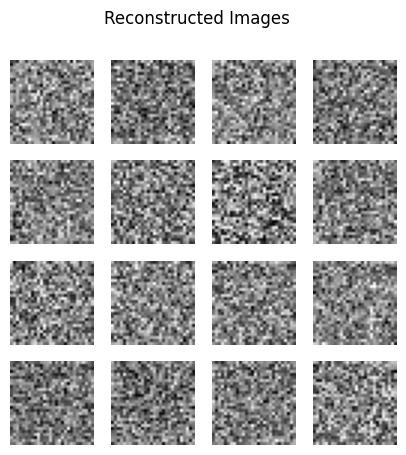

In [ ]:
batch = next(iter(valid_dl))
images,labels = batch
batch = to_device(batch)
preds = model(batch[0]).detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [ ]:
epochs = 20
lr = 3e-2
opt = optim.Adam(model.parameters(),lr = lr, eps = 1e-5)
sched = optim.

In [ ]:
# model = model.cpu()
# torch.save(model,'autoencoder.pth')

In [ ]:
model = torch.load('autoencoder.pth')

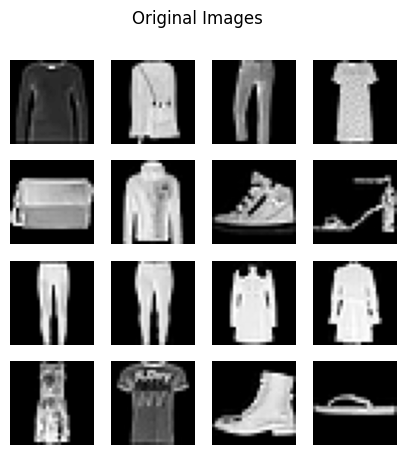

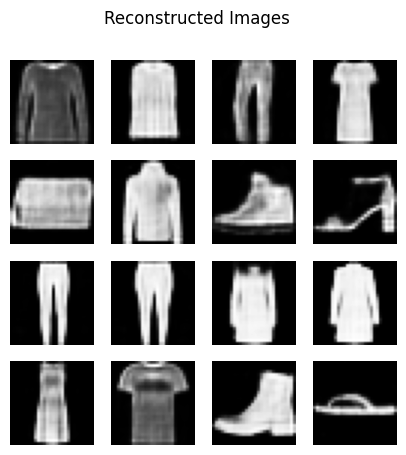

In [ ]:
batch = next(iter(valid_dl))
preds = model(batch[0]).detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

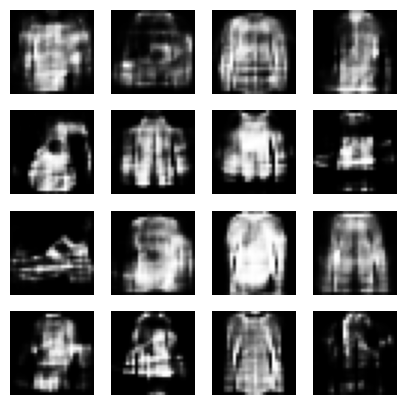

In [ ]:
random_noise = torch.randn(16,1,28,28)
preds = model(random_noise).detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

## VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU())
        
        self.mu = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))

        self.logvar = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return self.decoder(z),mu,logvar

In [ ]:
def KLDivergence_loss(input, target):
    _ , mu, logvar = input
    KLD = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    return KLD

def BCE_loss(input, target):
    BCE = F.binary_cross_entropy_with_logits(input[0], target)
    return BCE

def vae_loss_func(input, target):
    BCE = BCE_loss(input, target)
    KLD = KLDivergence_loss(input, target)
    return BCE + KLD

In [ ]:
model = VAE().to(def_device)

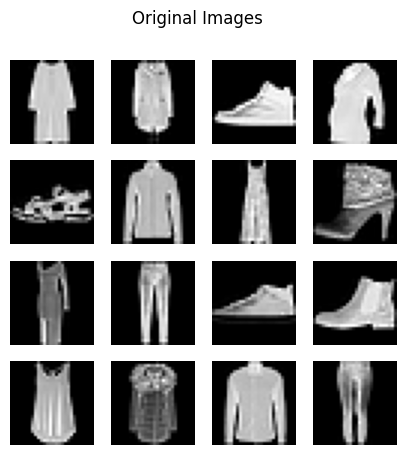

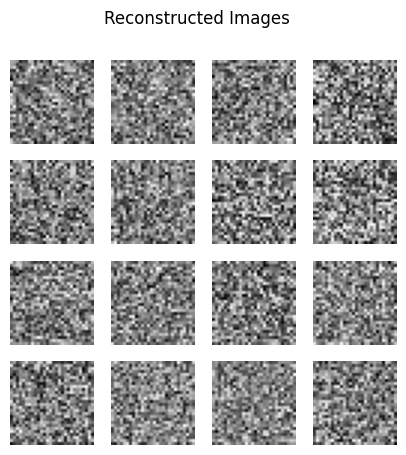

In [ ]:
batch = next(iter(valid_dl))
images,labels = batch
batch = to_device(batch)
preds = model(batch[0])[0].detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [ ]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
opt = partial(optim.Adam, eps=1e-5)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
metrics = MetricsCB(kld=FuncMetric(KLDivergence_loss), bce=FuncMetric(BCE_loss))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision(), ChangeLabels()]
learn = Learner(model, dls, vae_loss_func, lr=lr, cbs=cbs, opt_func=opt)
# learn.fit(epochs)

In [ ]:
# model = model.cpu()
# torch.save(model,'VAE.pth')

In [ ]:
model = torch.load('VAE.pth')

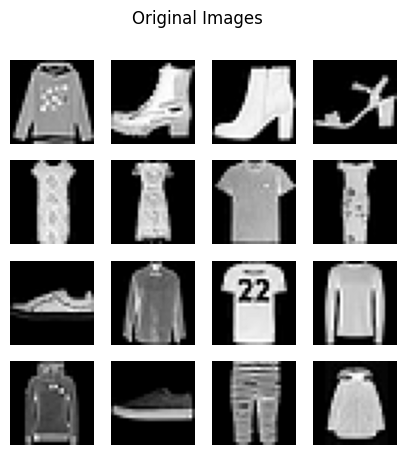

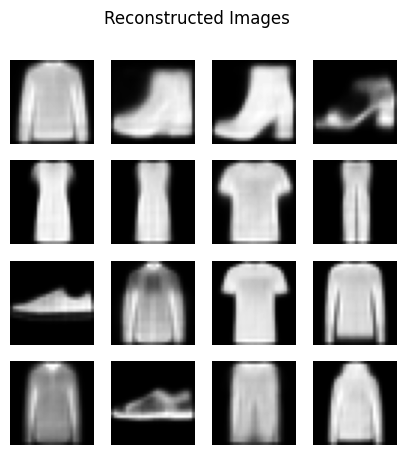

In [ ]:
batch = next(iter(valid_dl))
preds = model(batch[0])[0].detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

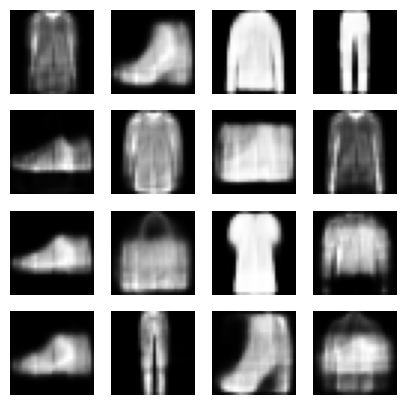

In [ ]:
random_noise = torch.randn(16,1,28,28)
preds = model(random_noise)[0].detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')